# George_AstroML_Fig8-11

OrderedDict([('kernel:k1:log_constant', 0.0), ('kernel:k2:metric:log_M_0_0', -2.3025850929940455)])
Initial ln-likelihood: -2257.31
      fun: 148.5842461338155
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.01915888e-06,   9.35694250e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 9
      nit: 8
   status: 0
  success: True
        x: array([ 2.82292916, -1.19997591])

Final ln-likelihood: -148.58
OrderedDict([('kernel:k1:log_constant', 2.8229291562048986), ('kernel:k2:metric:log_M_0_0', -1.199975911438236)])


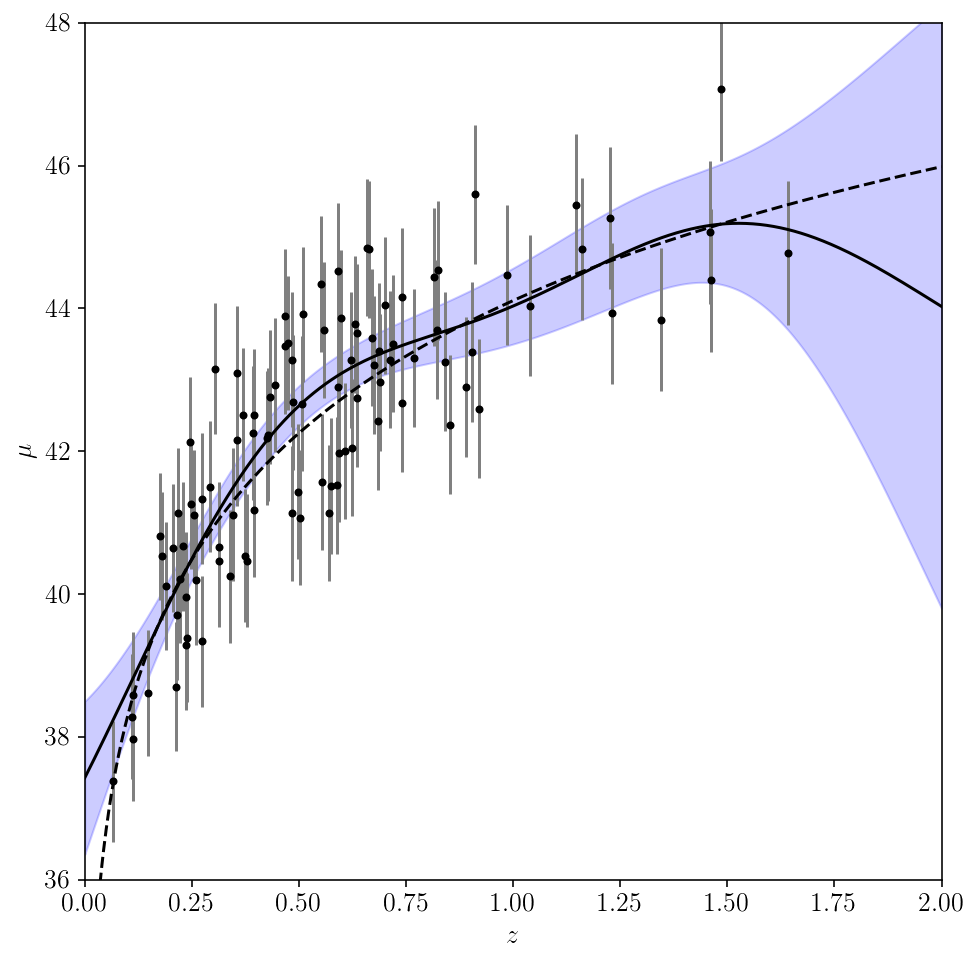

In [82]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
import george
from george import kernels
from scipy.optimize import minimize
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=13, usetex=True)

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray([cosmo.mu(redshift) for redshift in z] )#

#------------------------------------------------------------
# fit the data
# Mesh the input space for evaluations of the real function,
# the prediction and its MSE
z_fit = np.linspace(0, 2, 1000)
k =  1.0 * kernels.ExpSquaredKernel(metric=1e-1)

gp = george.GP(k,  mean=np.mean(mu_sample))
gp.compute(z_sample, dmu)

print(gp.get_parameter_dict())
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(z_sample)))


# define the objective function and 
# its gradient 
def neg_ln_like(p,y,gp):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p,y,gp):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

metric_min, metric_max = 1e-2,1
bounds = [(None,None), (np.log(metric_min), np.log(metric_max))]
result = minimize(neg_ln_like, gp.get_parameter_vector(), 
                  jac=grad_neg_ln_like,
                 args = (mu_sample, gp), bounds=bounds)

print(result)
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(mu_sample)))

y_pred, MSE = gp.predict(mu_sample, z_fit[:, None], return_var =True)
sigma = np.sqrt(MSE)
print(gp.get_parameter_dict())

%matplotlib inline
%config InlineBackend.figure_format='retina'
#------------------------------------------------------------
# Plot the gaussian process
#  gaussian process allows computation of the error at each point
#  so we will show this as a shaded region
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(111)

ax.plot(z, mu_true, '--k')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', markersize=6)
ax.plot(z_fit, y_pred, '-k')
ax.fill_between(z_fit, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                alpha=0.2, color='b', label='95% confidence interval')

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.set_xlim(0, 2)
ax.set_ylim(36, 48)

plt.savefig('AstroML_Fig8-11_George.png', bbox_inches='tight')